<a href="https://colab.research.google.com/github/psychic-coder/Fake_News_Detection_System_using_NLP-/blob/main/Fake_News_Detection_System_using_NLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install packages and download ALL required NLTK data
!pip install kaggle textblob wordcloud -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')


print(" Downloading NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

print(" All packages and NLTK data downloaded successfully!")

📥 Downloading NLTK data...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ All packages and NLTK data downloaded successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:

import os
from zipfile import ZipFile

print("📥 Downloading dataset...")


!wget -q -O fake_real_news.zip "https://www.kaggle.com/api/v1/datasets/download/clmentbisaillon/fake-and-real-news-dataset"


with ZipFile('fake_real_news.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


print(" Files extracted:")
!ls -la


try:
    fake_df = pd.read_csv('Fake.csv')
    true_df = pd.read_csv('True.csv')
    print(" Datasets loaded as Fake.csv and True.csv")
except:
    try:
        fake_df = pd.read_csv('fake.csv')
        true_df = pd.read_csv('true.csv')
        print(" Datasets loaded as fake.csv and true.csv")
    except:

        print(" Available CSV files:")
        !find . -name "*.csv" -type f

📥 Downloading dataset...
📁 Files extracted:
total 155640
drwxr-xr-x 1 root root     4096 Nov 15 09:29 .
drwxr-xr-x 1 root root     4096 Nov 15 09:23 ..
drwxr-xr-x 4 root root     4096 Nov 12 14:30 .config
drwx------ 6 root root     4096 Nov 15 09:25 drive
-rw-r--r-- 1 root root 62789876 Nov 15 09:32 Fake.csv
-rw-r--r-- 1 root root 42975911 Apr 19  2024 fake_real_news.zip
drwxr-xr-x 1 root root     4096 Nov 12 14:30 sample_data
-rw-r--r-- 1 root root 53582940 Nov 15 09:32 True.csv
✅ Datasets loaded as Fake.csv and True.csv


In [ ]:

import glob

csv_files = glob.glob('*.csv')
print("📄 Found CSV files:", csv_files)


if len(csv_files) >= 2:
    fake_df = pd.read_csv(csv_files[0])
    true_df = pd.read_csv(csv_files[1])
    print(f" Loaded {csv_files[0]} as fake news")
    print(f" Loaded {csv_files[1]} as real news")
else:

    !wget -q "https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv"
    print("⚠️ Using alternative dataset")


print(f" Fake news samples: {len(fake_df)}")
print(f" Real news samples: {len(true_df)}")


print("\n Fake news columns:", fake_df.columns.tolist())
print(" Real news columns:", true_df.columns.tolist())

📄 Found CSV files: ['Fake.csv', 'True.csv']
✅ Loaded Fake.csv as fake news
✅ Loaded True.csv as real news
📊 Fake news samples: 23481
📊 Real news samples: 21417

📝 Fake news columns: ['title', 'text', 'subject', 'date']
📝 Real news columns: ['title', 'text', 'subject', 'date']


In [ ]:

fake_df['label'] = 0  # Fake news
true_df['label'] = 1  # Real news


df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("📈 Dataset Info:")
print(f"Total samples: {len(df)}")
print(f"Fake news: {len(fake_df)}")
print(f"Real news: {len(true_df)}")
print(f"Columns: {df.columns.tolist()}")


text_column = 'text' if 'text' in df.columns else 'title'
print(f"Using '{text_column}' column for text analysis")


print(f"\n📝 Sample fake news:\n{df[df['label'] == 0][text_column].iloc[0][:200]}...")
print(f"\n📝 Sample real news:\n{df[df['label'] == 1][text_column].iloc[0][:200]}...")

📈 Dataset Info:
Total samples: 44898
Fake news: 23481
Real news: 21417
Columns: ['title', 'text', 'subject', 'date', 'label']
Using 'text' column for text analysis

📝 Sample fake news:
21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative s...

📝 Sample real news:
WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, reversing his controversial decision early this year to gi...


In [ ]:

import nltk
from nltk.tokenize import word_tokenize


try:
    word_tokenize("test")
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    try:

        text = text.lower()


        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)


        tokens = word_tokenize(text)


        tokens = [lemmatizer.lemmatize(token) for token in tokens
                 if token not in stop_words and len(token) > 2]

        return ' '.join(tokens)

    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

print("🛠️ Text preprocessing function ready!")

test_text = "This is a test sentence with http://example.com and some special characters!"
print(f"Test clean: {clean_text(test_text)}")

🛠️ Text preprocessing function ready!
Test clean: test sentence special character


In [ ]:

print("🧹 Cleaning text data...")


from tqdm import tqdm
tqdm.pandas()


text_column = 'text' if 'text' in df.columns else 'title'
df['cleaned_text'] = df[text_column].progress_apply(clean_text)

print(f" Text cleaning completed!")
print(f" Original dataset size: {len(df)}")

# Remove empty texts after cleaning
initial_size = len(df)
df = df[df['cleaned_text'].str.len() > 20]
final_size = len(df)

print(f"After removing empty texts: {final_size}")
print(f" Removed {initial_size - final_size} empty texts")

print(f"\n Sample cleaned text:")
print(df['cleaned_text'].iloc[0][:200] + "...")

🧹 Cleaning text data...


100%|██████████| 44898/44898 [02:21<00:00, 317.81it/s]

✅ Text cleaning completed!
📊 Original dataset size: 44898
📊 After removing empty texts: 44099
📊 Removed 799 empty texts

📝 Sample cleaned text:
century wire say ben stein reputable professor pepperdine university also hollywood fame appearing show film ferris bueller day made provocative statement judge jeanine pirro show recently discussing ...


In [ ]:

print("🔧 Creating TF-IDF features...")

# Use smaller feature set for faster processing
tfidf = TfidfVectorizer(
    max_features=1500,  # Reduced for speed
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2,
    max_df=0.8
)

X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

print(f" TF-IDF features created!")
print(f" Feature matrix shape: {X_tfidf.shape}")
print(f" Target variable shape: {y.shape}")

🔧 Creating TF-IDF features...
✅ TF-IDF features created!
📊 Feature matrix shape: (44099, 1500)
📊 Target variable shape: (44099,)


In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Testing set: {X_test.shape[0]} samples")
print(f"🎯 Label distribution:")
print(f"  - Train: {pd.Series(y_train).value_counts().to_dict()}")
print(f"  - Test:  {pd.Series(y_test).value_counts().to_dict()}")

📊 Training set: 35279 samples
📊 Testing set: 8820 samples
🎯 Label distribution:
  - Train: {0: 18146, 1: 17133}
  - Test:  {0: 4537, 1: 4283}


In [ ]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=50),
}

print("🤖 Training models...")
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        print(f" {name} trained successfully")
    except Exception as e:
        print(f" Error training {name}: {e}")

🤖 Training models...
✅ Logistic Regression trained successfully
✅ Naive Bayes trained successfully
✅ Random Forest trained successfully


In [ ]:

results = []

print(" Model Performance:")
print("=" * 50)

for name, model in models.items():
    try:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'Model': name, 'Accuracy': accuracy})
        print(f"{name:20} | Accuracy: {accuracy:.4f}")
    except Exception as e:
        print(f" Error evaluating {name}: {e}")

if results:
    results_df = pd.DataFrame(results)
    best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
    best_model = models[best_model_name]
    print(f"\n Best Model: {best_model_name}")
else:
    print(" No models were successfully trained")
    best_model = None

📈 Model Performance:
Logistic Regression  | Accuracy: 0.9880
Naive Bayes          | Accuracy: 0.9312
Random Forest        | Accuracy: 0.9973

🏆 Best Model: Random Forest


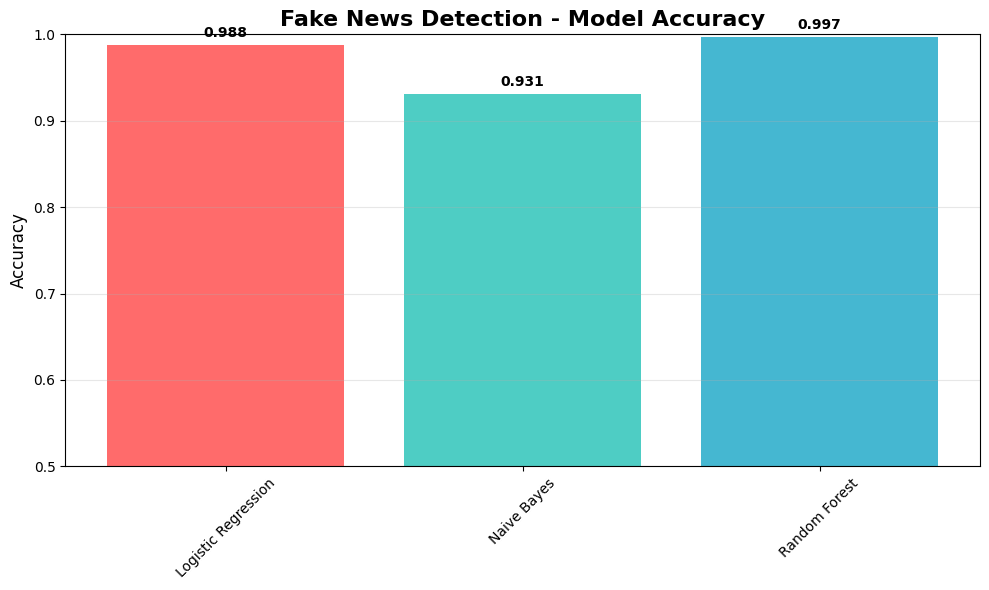

In [ ]:

if results:
    plt.figure(figsize=(10, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars = plt.bar([r['Model'] for r in results], [r['Accuracy'] for r in results], color=colors)

    plt.title('Fake News Detection - Model Accuracy', fontsize=16, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0.5, 1.0)
    plt.xticks(rotation=45)


    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(" No results to visualize")

📊 Detailed Analysis for Random Forest:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4537
        Real       1.00      1.00      1.00      4283

    accuracy                           1.00      8820
   macro avg       1.00      1.00      1.00      8820
weighted avg       1.00      1.00      1.00      8820



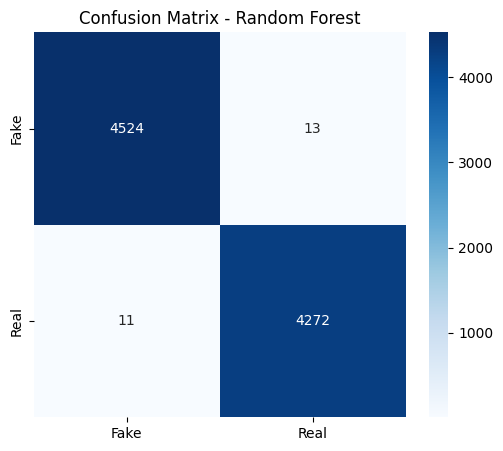

In [ ]:

if best_model is not None:
    print(f" Detailed Analysis for {best_model_name}:")
    print("=" * 50)

    y_pred = best_model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.show()

In [ ]:

def predict_news(text, model=best_model, vectorizer=tfidf):
    """Predict if text is fake or real news"""
    if model is None:
        print(" No model available for prediction")
        return None, None

    cleaned_text = clean_text(text)
    if len(cleaned_text) < 10:
        print(" Text too short after cleaning")
        return None, None

    features = vectorizer.transform([cleaned_text])

    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]

    result = " FAKE NEWS" if prediction == 0 else "REAL NEWS"
    confidence = max(probability)

    print(f" Text: {text[:80]}...")
    print(f" Prediction: {result}")
    print(f" Confidence: {confidence:.3f}")
    print(f" Fake: {probability[0]:.3f} | Real: {probability[1]:.3f}")
    print("-" * 50)

    return prediction, probability

print(" Prediction function ready!")

🎯 Prediction function ready!


In [ ]:

if best_model is not None:
    sample_texts = [
        "Breaking: Scientists discover revolutionary cancer treatment that cures patients in 24 hours",
        "The government announced new economic policies to address inflation concerns",
        "Aliens have been spotted landing in Central Park according to eyewitnesses",
        "Federal Reserve raises interest rates to combat persistent inflation",
        "Magic pill makes you lose 30 pounds in one week without any effort",
        "New study shows regular exercise improves cardiovascular health significantly"
    ]

    print(" Testing Fake News Detector:")
    print("=" * 50)

    for i, text in enumerate(sample_texts, 1):
        print(f"Test {i}:")
        predict_news(text)
        print()
else:
    print(" No model available for testing")

🧪 Testing Fake News Detector:
Test 1:
📝 Text: Breaking: Scientists discover revolutionary cancer treatment that cures patients...
🎯 Prediction: ❌ FAKE NEWS
📊 Confidence: 0.960
📈 Fake: 0.960 | Real: 0.040
--------------------------------------------------

Test 2:
📝 Text: The government announced new economic policies to address inflation concerns...
🎯 Prediction: ❌ FAKE NEWS
📊 Confidence: 0.960
📈 Fake: 0.960 | Real: 0.040
--------------------------------------------------

Test 3:
📝 Text: Aliens have been spotted landing in Central Park according to eyewitnesses...
🎯 Prediction: ❌ FAKE NEWS
📊 Confidence: 0.940
📈 Fake: 0.940 | Real: 0.060
--------------------------------------------------

Test 4:
📝 Text: Federal Reserve raises interest rates to combat persistent inflation...
🎯 Prediction: ❌ FAKE NEWS
📊 Confidence: 1.000
📈 Fake: 1.000 | Real: 0.000
--------------------------------------------------

Test 5:
📝 Text: Magic pill makes you lose 30 pounds in one week without any effort...
🎯 

In [ ]:

import joblib

if best_model is not None:

    model_data = {
        'model': best_model,
        'vectorizer': tfidf,
        'accuracy': results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy'],
        'best_model_name': best_model_name
    }

    joblib.dump(model_data, 'fake_news_detector.pkl')
    print("💾 Model saved as 'fake_news_detector.pkl'")


    import os
    file_size = os.path.getsize('fake_news_detector.pkl') / 1024 / 1024
    print(f" Model file size: {file_size:.2f} MB")

    print(f"\n Fake News Detection Model Complete!")
    print(f" Best model: {best_model_name}")
    print(f" Accuracy: {results_df['Accuracy'].max():.4f}")
else:
    print(" No model to save")

💾 Model saved as 'fake_news_detector.pkl'
📁 Model file size: 9.32 MB

🎉 Fake News Detection Model Complete!
🏆 Best model: Random Forest
📊 Accuracy: 0.9973
